In [1]:
# Load the huggingface sst2 dataset
from datasets import load_dataset

dataset = load_dataset("sst2")


f:\Programs\anaconda3\envs\ssm_hw5\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print(dataset)
print(dataset["train"][0])

DatasetDict({
    train: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 67349
    })
    validation: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 872
    })
    test: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 1821
    })
})
{'idx': 0, 'sentence': 'hide new secretions from the parental units ', 'label': 0}


In [3]:
num_labels = len(set(dataset["train"]["label"]))
print(num_labels)

2


In [4]:
# Delete original test set, split the train set into train and validation, and assign original validation set to test set

dataset["test"] = dataset["validation"]

train_size = int(len(dataset["train"]) * 0.98)
train_set = dataset["train"].select(list(range(train_size)))
validation_set = dataset["train"].select(list(range(train_size, len(dataset["train"]))))
dataset["train"] = train_set
dataset["validation"] = validation_set

print(dataset)

DatasetDict({
    train: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 66002
    })
    validation: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 1347
    })
    test: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 872
    })
})


In [5]:
from transformers import AutoTokenizer, RobertaModel, RobertaForSequenceClassification
import torch

tokenizer = AutoTokenizer.from_pretrained("roberta-base")
# model = RobertaModel.from_pretrained("FacebookAI/roberta-base")
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=num_labels)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
# BitFit: freeze everything except for bias terms 

for name, param in model.named_parameters():
    if "bias" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

total_params = sum(param.numel() for param in model.parameters())
trainable_params = sum(param.numel() for param in model.parameters() if param.requires_grad)
print(f"Total params: {total_params}")
print(f"Trainable params: {trainable_params}")
print(f"Percentage trainable: {trainable_params / total_params * 100:.2f}%")

Total params: 124647170
Trainable params: 102914
Percentage trainable: 0.08%


In [7]:
# for name, param in model.named_parameters():
#     print(f"{name}: {param.requires_grad}")

In [8]:
# Tokenize the dataset
def tokenize_function(examples):
    return tokenizer(examples["sentence"], padding="max_length", truncation=True)

tokenized_dataset = dataset.map(tokenize_function, batched=True)

# Print the first example of the training set
print(tokenized_dataset["train"][0])



Map: 100%|██████████| 1347/1347 [00:00<00:00, 7736.37 examples/s]

{'idx': 0, 'sentence': 'hide new secretions from the parental units ', 'label': 0, 'input_ids': [0, 37265, 92, 3556, 2485, 31, 5, 20536, 2833, 1437, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [9]:
from transformers import Trainer, TrainingArguments
from datasets import load_metric
import numpy as np
import logging

metric = load_metric("accuracy")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    result = metric.compute(predictions=predictions, references=labels)

    return result


logging.basicConfig(level=logging.INFO)

step_size = 500
lr = 1e-4

training_args = TrainingArguments(
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=1,
    logging_dir='./logs',
    logging_steps=step_size,
    do_train=True,
    do_eval=True,
    evaluation_strategy="steps",
    eval_steps=step_size,
    output_dir='./bitfit_results',
    overwrite_output_dir=True,
    save_steps=step_size,
    save_total_limit=20,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    learning_rate=lr,
    # warmup_steps=500,
)

trainer = Trainer(
    model=model, 
    args=training_args,
    train_dataset=tokenized_dataset["train"], 
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()




C:\Users\Shaobo Liang\AppData\Local\Temp\ipykernel_59376\2960877662.py:6: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")
f:\Programs\anaconda3\envs\ssm_hw5\lib\site-packages\datasets\load.py:753: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.17.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
f:\Programs\anaconda3\envs\ssm_hw5\lib\site-packages\accelerate\accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` i

{'loss': 0.6896, 'learning_rate': 9.696988061329618e-05, 'epoch': 0.03}


                                                   
  3%|▎         | 500/16501 [01:56<48:53,  5.45it/s]

{'eval_loss': 0.6840893030166626, 'eval_accuracy': 0.5664439495174461, 'eval_runtime': 26.7888, 'eval_samples_per_second': 50.282, 'eval_steps_per_second': 12.58, 'epoch': 0.03}


  6%|▌         | 1000/16501 [03:28<47:20,  5.46it/s]  

{'loss': 0.6858, 'learning_rate': 9.393976122659234e-05, 'epoch': 0.06}


                                                    
  6%|▌         | 1000/16501 [03:54<47:20,  5.46it/s]Checkpoint destination directory ./bitfit_results\checkpoint-1000 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.6783822178840637, 'eval_accuracy': 0.5664439495174461, 'eval_runtime': 26.6381, 'eval_samples_per_second': 50.567, 'eval_steps_per_second': 12.651, 'epoch': 0.06}


  9%|▉         | 1500/16501 [05:27<45:40,  5.47it/s]   

{'loss': 0.5842, 'learning_rate': 9.09096418398885e-05, 'epoch': 0.09}


                                                    
  9%|▉         | 1500/16501 [05:53<45:40,  5.47it/s]Checkpoint destination directory ./bitfit_results\checkpoint-1500 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.4287959337234497, 'eval_accuracy': 0.8433556050482554, 'eval_runtime': 26.2213, 'eval_samples_per_second': 51.37, 'eval_steps_per_second': 12.852, 'epoch': 0.09}


 12%|█▏        | 2000/16501 [07:22<42:50,  5.64it/s]   

{'loss': 0.4014, 'learning_rate': 8.787952245318465e-05, 'epoch': 0.12}


                                                    
 12%|█▏        | 2000/16501 [07:48<42:50,  5.64it/s]Checkpoint destination directory ./bitfit_results\checkpoint-2000 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.410177081823349, 'eval_accuracy': 0.85003711952487, 'eval_runtime': 25.8704, 'eval_samples_per_second': 52.067, 'eval_steps_per_second': 13.026, 'epoch': 0.12}


 15%|█▌        | 2500/16501 [09:17<41:16,  5.65it/s]   

{'loss': 0.3712, 'learning_rate': 8.484940306648083e-05, 'epoch': 0.15}


                                                    
 15%|█▌        | 2500/16501 [09:42<41:16,  5.65it/s]Checkpoint destination directory ./bitfit_results\checkpoint-2500 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.32848456501960754, 'eval_accuracy': 0.8834446919079436, 'eval_runtime': 25.9136, 'eval_samples_per_second': 51.98, 'eval_steps_per_second': 13.005, 'epoch': 0.15}


 18%|█▊        | 3000/16501 [11:11<35:06,  6.41it/s]   

{'loss': 0.3638, 'learning_rate': 8.181928367977699e-05, 'epoch': 0.18}


                                                    
 18%|█▊        | 3000/16501 [11:37<35:06,  6.41it/s]

{'eval_loss': 0.3271775245666504, 'eval_accuracy': 0.8923533778767632, 'eval_runtime': 25.8925, 'eval_samples_per_second': 52.023, 'eval_steps_per_second': 13.015, 'epoch': 0.18}


 21%|██        | 3500/16501 [13:06<38:32,  5.62it/s]   

{'loss': 0.3519, 'learning_rate': 7.878916429307314e-05, 'epoch': 0.21}


                                                    
 21%|██        | 3500/16501 [13:32<38:32,  5.62it/s]

{'eval_loss': 0.3729550242424011, 'eval_accuracy': 0.874536005939124, 'eval_runtime': 25.841, 'eval_samples_per_second': 52.126, 'eval_steps_per_second': 13.041, 'epoch': 0.21}


 24%|██▍       | 4000/16501 [15:01<37:00,  5.63it/s]   

{'loss': 0.3716, 'learning_rate': 7.575904490636932e-05, 'epoch': 0.24}


                                                    
 24%|██▍       | 4000/16501 [15:27<37:00,  5.63it/s]

{'eval_loss': 0.347115159034729, 'eval_accuracy': 0.8841870824053452, 'eval_runtime': 25.8817, 'eval_samples_per_second': 52.044, 'eval_steps_per_second': 13.021, 'epoch': 0.24}


 27%|██▋       | 4500/16501 [16:55<35:19,  5.66it/s]   

{'loss': 0.3556, 'learning_rate': 7.272892551966548e-05, 'epoch': 0.27}


                                                    
 27%|██▋       | 4500/16501 [17:21<35:19,  5.66it/s]

{'eval_loss': 0.3300151526927948, 'eval_accuracy': 0.89086859688196, 'eval_runtime': 25.8858, 'eval_samples_per_second': 52.036, 'eval_steps_per_second': 13.019, 'epoch': 0.27}


 30%|███       | 5000/16501 [18:50<34:16,  5.59it/s]   

{'loss': 0.3536, 'learning_rate': 6.969880613296165e-05, 'epoch': 0.3}


                                                    
 30%|███       | 5000/16501 [19:15<34:16,  5.59it/s]

{'eval_loss': 0.3392087519168854, 'eval_accuracy': 0.8901262063845583, 'eval_runtime': 25.157, 'eval_samples_per_second': 53.544, 'eval_steps_per_second': 13.396, 'epoch': 0.3}


 33%|███▎      | 5500/16501 [20:45<33:00,  5.55it/s]   

{'loss': 0.339, 'learning_rate': 6.666868674625781e-05, 'epoch': 0.33}


                                                    
 33%|███▎      | 5500/16501 [21:11<33:00,  5.55it/s]

{'eval_loss': 0.3416004776954651, 'eval_accuracy': 0.89086859688196, 'eval_runtime': 26.1282, 'eval_samples_per_second': 51.554, 'eval_steps_per_second': 12.898, 'epoch': 0.33}


 36%|███▋      | 6000/16501 [22:39<30:49,  5.68it/s]   

{'loss': 0.3342, 'learning_rate': 6.363856735955397e-05, 'epoch': 0.36}


                                                    
 36%|███▋      | 6000/16501 [23:05<30:49,  5.68it/s]

{'eval_loss': 0.33435213565826416, 'eval_accuracy': 0.8923533778767632, 'eval_runtime': 26.3743, 'eval_samples_per_second': 51.073, 'eval_steps_per_second': 12.778, 'epoch': 0.36}


 39%|███▉      | 6500/16501 [24:33<29:56,  5.57it/s]   

{'loss': 0.3489, 'learning_rate': 6.060844797285013e-05, 'epoch': 0.39}


                                                    
 39%|███▉      | 6500/16501 [25:00<29:56,  5.57it/s]

{'eval_loss': 0.34109947085380554, 'eval_accuracy': 0.8901262063845583, 'eval_runtime': 26.1568, 'eval_samples_per_second': 51.497, 'eval_steps_per_second': 12.884, 'epoch': 0.39}


 42%|████▏     | 7000/16501 [26:29<27:32,  5.75it/s]   

{'loss': 0.373, 'learning_rate': 5.75783285861463e-05, 'epoch': 0.42}


                                                    
 42%|████▏     | 7000/16501 [26:54<27:32,  5.75it/s]

{'eval_loss': 0.33677491545677185, 'eval_accuracy': 0.8923533778767632, 'eval_runtime': 25.3492, 'eval_samples_per_second': 53.138, 'eval_steps_per_second': 13.294, 'epoch': 0.42}


 45%|████▌     | 7500/16501 [28:24<26:34,  5.64it/s]   

{'loss': 0.3235, 'learning_rate': 5.454820919944246e-05, 'epoch': 0.45}


                                                    
 45%|████▌     | 7500/16501 [28:50<26:34,  5.64it/s]

{'eval_loss': 0.3356819152832031, 'eval_accuracy': 0.894580549368968, 'eval_runtime': 25.929, 'eval_samples_per_second': 51.95, 'eval_steps_per_second': 12.997, 'epoch': 0.45}


 48%|████▊     | 8000/16501 [30:18<25:05,  5.64it/s]   

{'loss': 0.3303, 'learning_rate': 5.1518089812738623e-05, 'epoch': 0.48}


                                                    
 48%|████▊     | 8000/16501 [30:44<25:05,  5.64it/s]

{'eval_loss': 0.3470970690250397, 'eval_accuracy': 0.89086859688196, 'eval_runtime': 25.9725, 'eval_samples_per_second': 51.863, 'eval_steps_per_second': 12.975, 'epoch': 0.48}


 52%|█████▏    | 8500/16501 [32:13<23:35,  5.65it/s]   

{'loss': 0.3214, 'learning_rate': 4.848797042603479e-05, 'epoch': 0.52}


                                                    
 52%|█████▏    | 8500/16501 [32:39<23:35,  5.65it/s]

{'eval_loss': 0.33172544836997986, 'eval_accuracy': 0.894580549368968, 'eval_runtime': 25.8041, 'eval_samples_per_second': 52.201, 'eval_steps_per_second': 13.06, 'epoch': 0.52}


 55%|█████▍    | 9000/16501 [34:08<22:00,  5.68it/s]   

{'loss': 0.3166, 'learning_rate': 4.545785103933095e-05, 'epoch': 0.55}


                                                    
 55%|█████▍    | 9000/16501 [34:34<22:00,  5.68it/s]

{'eval_loss': 0.32822030782699585, 'eval_accuracy': 0.896807720861173, 'eval_runtime': 25.6311, 'eval_samples_per_second': 52.553, 'eval_steps_per_second': 13.148, 'epoch': 0.55}


 58%|█████▊    | 9500/16501 [36:02<20:27,  5.71it/s]   

{'loss': 0.3301, 'learning_rate': 4.242773165262712e-05, 'epoch': 0.58}


                                                    
 58%|█████▊    | 9500/16501 [36:28<20:27,  5.71it/s]

{'eval_loss': 0.32080593705177307, 'eval_accuracy': 0.8938381588715665, 'eval_runtime': 25.8501, 'eval_samples_per_second': 52.108, 'eval_steps_per_second': 13.037, 'epoch': 0.58}


 61%|██████    | 10000/16501 [37:57<19:03,  5.68it/s]  

{'loss': 0.3314, 'learning_rate': 3.939761226592328e-05, 'epoch': 0.61}


                                                     
 61%|██████    | 10000/16501 [38:22<19:03,  5.68it/s]

{'eval_loss': 0.3369462192058563, 'eval_accuracy': 0.8953229398663697, 'eval_runtime': 25.8456, 'eval_samples_per_second': 52.117, 'eval_steps_per_second': 13.039, 'epoch': 0.61}


 64%|██████▎   | 10500/16501 [39:51<17:05,  5.85it/s]   

{'loss': 0.3286, 'learning_rate': 3.6367492879219446e-05, 'epoch': 0.64}


                                                     
 64%|██████▎   | 10500/16501 [40:17<17:05,  5.85it/s]

{'eval_loss': 0.3279532790184021, 'eval_accuracy': 0.896807720861173, 'eval_runtime': 25.1569, 'eval_samples_per_second': 53.544, 'eval_steps_per_second': 13.396, 'epoch': 0.64}


 67%|██████▋   | 11000/16501 [41:46<16:40,  5.50it/s]   

{'loss': 0.3357, 'learning_rate': 3.3337373492515605e-05, 'epoch': 0.67}


                                                     
 67%|██████▋   | 11000/16501 [42:12<16:40,  5.50it/s]

{'eval_loss': 0.3277440369129181, 'eval_accuracy': 0.8953229398663697, 'eval_runtime': 25.6465, 'eval_samples_per_second': 52.522, 'eval_steps_per_second': 13.14, 'epoch': 0.67}


 70%|██████▉   | 11500/16501 [43:41<15:02,  5.54it/s]   

{'loss': 0.3375, 'learning_rate': 3.0307254105811774e-05, 'epoch': 0.7}


                                                     
 70%|██████▉   | 11500/16501 [44:07<15:02,  5.54it/s]

{'eval_loss': 0.3142925798892975, 'eval_accuracy': 0.9005196733481812, 'eval_runtime': 25.9524, 'eval_samples_per_second': 51.903, 'eval_steps_per_second': 12.985, 'epoch': 0.7}


 73%|███████▎  | 12000/16501 [45:35<13:30,  5.56it/s]   

{'loss': 0.3245, 'learning_rate': 2.7277134719107933e-05, 'epoch': 0.73}


                                                     
 73%|███████▎  | 12000/16501 [46:01<13:30,  5.56it/s]

{'eval_loss': 0.32960397005081177, 'eval_accuracy': 0.8960653303637713, 'eval_runtime': 26.1555, 'eval_samples_per_second': 51.5, 'eval_steps_per_second': 12.884, 'epoch': 0.73}


 76%|███████▌  | 12500/16501 [47:31<11:42,  5.69it/s]   

{'loss': 0.3032, 'learning_rate': 2.4247015332404095e-05, 'epoch': 0.76}


                                                     
 76%|███████▌  | 12500/16501 [47:56<11:42,  5.69it/s]

{'eval_loss': 0.3321285843849182, 'eval_accuracy': 0.8975501113585747, 'eval_runtime': 25.5093, 'eval_samples_per_second': 52.804, 'eval_steps_per_second': 13.211, 'epoch': 0.76}


 79%|███████▉  | 13000/16501 [49:25<10:24,  5.60it/s]  

{'loss': 0.303, 'learning_rate': 2.121689594570026e-05, 'epoch': 0.79}


                                                     
 79%|███████▉  | 13000/16501 [49:52<10:24,  5.60it/s]

{'eval_loss': 0.3369172215461731, 'eval_accuracy': 0.8953229398663697, 'eval_runtime': 26.1123, 'eval_samples_per_second': 51.585, 'eval_steps_per_second': 12.906, 'epoch': 0.79}


 82%|████████▏ | 13500/16501 [51:20<08:48,  5.68it/s]  

{'loss': 0.3085, 'learning_rate': 1.8186776558996423e-05, 'epoch': 0.82}


                                                     
 82%|████████▏ | 13500/16501 [51:46<08:48,  5.68it/s]

{'eval_loss': 0.32851892709732056, 'eval_accuracy': 0.8982925018559762, 'eval_runtime': 25.9881, 'eval_samples_per_second': 51.831, 'eval_steps_per_second': 12.967, 'epoch': 0.82}


 85%|████████▍ | 14000/16501 [53:15<07:28,  5.57it/s]  

{'loss': 0.3274, 'learning_rate': 1.515665717229259e-05, 'epoch': 0.85}


                                                     
 85%|████████▍ | 14000/16501 [53:41<07:28,  5.57it/s]

{'eval_loss': 0.3259906768798828, 'eval_accuracy': 0.9005196733481812, 'eval_runtime': 25.9099, 'eval_samples_per_second': 51.988, 'eval_steps_per_second': 13.007, 'epoch': 0.85}


 88%|████████▊ | 14500/16501 [55:10<05:50,  5.71it/s]  

{'loss': 0.3407, 'learning_rate': 1.2126537785588753e-05, 'epoch': 0.88}


                                                     
 88%|████████▊ | 14500/16501 [55:35<05:50,  5.71it/s]

{'eval_loss': 0.32649847865104675, 'eval_accuracy': 0.894580549368968, 'eval_runtime': 24.9685, 'eval_samples_per_second': 53.948, 'eval_steps_per_second': 13.497, 'epoch': 0.88}


 91%|█████████ | 15000/16501 [57:05<04:28,  5.58it/s]  

{'loss': 0.3285, 'learning_rate': 9.096418398884916e-06, 'epoch': 0.91}


                                                     
 91%|█████████ | 15000/16501 [57:31<04:28,  5.58it/s]

{'eval_loss': 0.32306981086730957, 'eval_accuracy': 0.8982925018559762, 'eval_runtime': 25.9384, 'eval_samples_per_second': 51.931, 'eval_steps_per_second': 12.992, 'epoch': 0.91}


 94%|█████████▍| 15500/16501 [58:59<02:56,  5.67it/s]  

{'loss': 0.3205, 'learning_rate': 6.0662990121810805e-06, 'epoch': 0.94}


                                                     
 94%|█████████▍| 15500/16501 [59:25<02:56,  5.67it/s]

{'eval_loss': 0.3226248621940613, 'eval_accuracy': 0.896807720861173, 'eval_runtime': 25.9139, 'eval_samples_per_second': 51.98, 'eval_steps_per_second': 13.005, 'epoch': 0.94}


 97%|█████████▋| 16000/16501 [1:00:54<01:28,  5.67it/s]

{'loss': 0.3301, 'learning_rate': 3.036179625477244e-06, 'epoch': 0.97}


                                                       
 97%|█████████▋| 16000/16501 [1:01:20<01:28,  5.67it/s]

{'eval_loss': 0.32276496291160583, 'eval_accuracy': 0.8975501113585747, 'eval_runtime': 25.8808, 'eval_samples_per_second': 52.046, 'eval_steps_per_second': 13.021, 'epoch': 0.97}


100%|█████████▉| 16500/16501 [1:02:49<00:00,  5.62it/s]  

{'loss': 0.2957, 'learning_rate': 6.060238773407673e-09, 'epoch': 1.0}


                                                       
100%|█████████▉| 16500/16501 [1:03:15<00:00,  5.62it/s]

{'eval_loss': 0.32211822271347046, 'eval_accuracy': 0.896807720861173, 'eval_runtime': 25.5583, 'eval_samples_per_second': 52.703, 'eval_steps_per_second': 13.186, 'epoch': 1.0}


100%|██████████| 16501/16501 [1:03:15<00:00,  4.35it/s]

{'train_runtime': 3795.9771, 'train_samples_per_second': 17.387, 'train_steps_per_second': 4.347, 'train_loss': 0.3654633444155912, 'epoch': 1.0}


TrainOutput(global_step=16501, training_loss=0.3654633444155912, metrics={'train_runtime': 3795.9771, 'train_samples_per_second': 17.387, 'train_steps_per_second': 4.347, 'train_loss': 0.3654633444155912, 'epoch': 1.0})

In [10]:
# print(trainer.state.log_history[0])
# for log in trainer.state.log_history:
#     print(log)

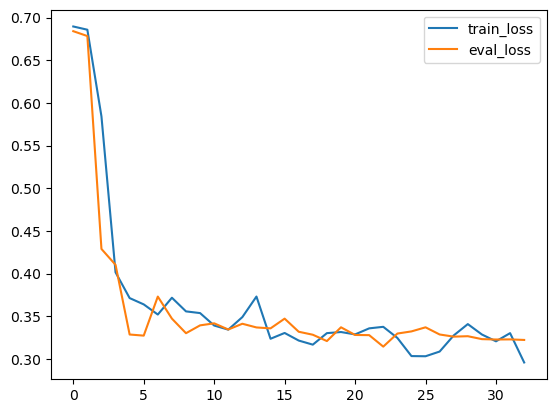

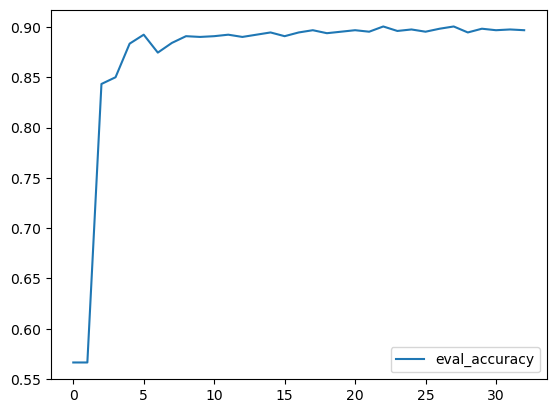

In [11]:
# Plot the results
import matplotlib.pyplot as plt

train_loss = []
eval_loss = []
eval_accuracy = []

for log in trainer.state.log_history:
    if 'loss' in log:
        train_loss.append(log["loss"])
    elif 'eval_loss' in log:
        eval_loss.append(log["eval_loss"])
        eval_accuracy.append(log["eval_accuracy"])

plt.plot(train_loss, label="train_loss")
plt.plot(eval_loss, label="eval_loss")
plt.legend()
plt.show()

plt.plot(eval_accuracy, label="eval_accuracy")
plt.legend()
plt.show()

In [12]:
# Load the best model and test 

# Find the best model checkpoint
max_accuracy = 0
for log in trainer.state.log_history:
    if 'eval_accuracy' in log:
        if log['eval_accuracy'] > max_accuracy:
            max_accuracy = log['eval_accuracy']
            best_checkpoint = log['step']

print(best_checkpoint)

best_model = RobertaForSequenceClassification.from_pretrained(f"./bitfit_results/checkpoint-{best_checkpoint}")

# Test the best model
trainer = Trainer(
    model=best_model, 
    args=training_args,
    train_dataset=tokenized_dataset["train"], 
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.evaluate()


11500


f:\Programs\anaconda3\envs\ssm_hw5\lib\site-packages\accelerate\accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(
100%|██████████| 218/218 [00:16<00:00, 13.54it/s]


{'eval_loss': 0.29504233598709106,
 'eval_accuracy': 0.9048165137614679,
 'eval_runtime': 16.176,
 'eval_samples_per_second': 53.907,
 'eval_steps_per_second': 13.477}